## 1.5 Upscaling EOBS then Masking


This notebook builds onto [1.4 Masking](1.4Mask.ipynb), by upscaling EOBS to the SEAS5 grid. We regrid EOBS to the SEAS5 grid so we can select the same grid cells in calculating the UK average for both datasets. The country outline would not be perfect, but the masks would be the same so the comparison would be fair. 

I use the [xesmf package](https://xesmf.readthedocs.io/en/latest/) for upscaling, a good example can be found in this [notebook](https://nbviewer.jupyter.org/github/geoschem/GEOSChem-python-tutorial/blob/master/Chapter03_regridding.ipynb). 

### Import packages

We need the packages regionmask for masking and xesmf for regridding. I cannot install xesmf into the UNSEEN-open environment without breaking my environment, so in this notebook I use a separate 'upscale' environment, as suggested by this [issue](https://github.com/JiaweiZhuang/xESMF/issues/47#issuecomment-582421822). I use the packages esmpy=7.1.0 xesmf=0.2.1 regionmask cartopy matplotlib xarray numpy netcdf4. 

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
##import packages
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

import regionmask       # Masking
import xesmf as xe      # Regridding

In [3]:
##We want the working directory to be the UNSEEN-open directory
pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
pwd #print the present working directory
os.chdir(pwd+'/../../') # Change the working directory to UNSEEN-open
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open/Notebooks/1.Download'

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

## Load SEAS5 and EOBS


From CDS, we retrieve SEAS5 in notebook [1.2 Retrieve](1.2Retrieve.ipynb) and concatenate the retrieved files in notebook [1.3 Merge](1.3Merge.ipynb). We create a netcdf file containing the dimensions lat, lon, time (35 years), number (25 ensembles) and leadtime (5 initialization months).

In [4]:
SEAS5 = xr.open_dataset('../UK_example/SEAS5/SEAS5.nc')
SEAS5

<xarray.Dataset>
Dimensions:    (latitude: 11, leadtime: 5, longitude: 14, number: 25, time: 35)
Coordinates:
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0
  * time       (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * leadtime   (leadtime) int64 2 3 4 5 6
Data variables:
    tprate     (leadtime, time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-13 14:49:43 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

And load EOBS netcdf with only February precipitation, resulting in 71 values, one for each year within 1950 - 2020 over the European domain (25N-75N x 40W-75E). 

In [5]:
EOBS = xr.open_dataset('../UK_example/EOBS/EOBS.nc')
EOBS

<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 71)
Coordinates:
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * time       (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29
Data variables:
    rr         (time, latitude, longitude) float32 ...

## Masking
Here we load the countries and create a mask for SEAS5 and for EOBS. 

### Load countries
Regionmask has predefined countries from [Natural Earth datasets](http://www.naturalearthdata.com) (shapefiles).

In [6]:
countries = regionmask.defined_regions.natural_earth.countries_50

### Create the mask
Now we create the mask for the SEAS5 grid. Only one timestep is needed to create the mask. This mask will lateron be used to mask all the timesteps. 

In [7]:
SEAS5_mask = countries.mask(SEAS5.sel(leadtime=2, number=0, time='1982'),
                            lon_name='longitude',
                            lat_name='latitude')
SEAS5_mask

<xarray.DataArray 'region' (latitude: 11, longitude: 14)>
array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  31.,  nan,  31.,  31.,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  31.,  31.,  31.,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan, 140.,  31.,  31.,  31.,  31.,  31.,  31.,  nan,
         nan,  nan,  nan],
       [ nan, 140., 140., 140., 140.,  nan,  nan,  nan,  nan,  31.,  31.,
         nan,  nan,  nan],
       [ nan,  nan, 140., 140., 140.,  nan,  nan,  31.,  31.,  31.,  31.,
         31.,  nan,  nan],
       [ nan, 140., 140., 140.,  nan,  nan,  31.,  31.,  31.,  31.,  31.,
         31.,  31.,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  31.,  31.,  31.,
         31.,  31., 160.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan, 160.]])
Coordinates:
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0

### EOBS
Now for EOBS, we want to upscale the dataset to the SEAS5 grid. We use the function `regridder(ds_in,ds_out,function)`, see the [docs](https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html). We have to rename the lat lon dimensions so the function can read them. 

We use bilinear interpolation first (i.e. function = 'bilinear'), because of its ease in implementation. However, the use of conservative areal average (function = 'conservative') for upscaling is preferred ([Kopparla, 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013GL057866)). 

In [8]:
regridder = xe.Regridder(EOBS.rename({'longitude': 'lon', 'latitude': 'lat'}), SEAS5.rename({'longitude': 'lon', 'latitude': 'lat'}),'bilinear')

Overwrite existing file: bilinear_201x464_11x14.nc 
 You can set reuse_weights=True to save computing time.


Now that we have the regridder, we can apply the regridder to our EOBS dataarray:

In [27]:
EOBS_upscaled = regridder(EOBS)
EOBS_upscaled

using dimensions ('latitude', 'longitude') from data variable rr as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (lat: 11, lon: 14, time: 71)
Coordinates:
  * time     (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29
  * lon      (lon) float32 -11.0 -10.0 -9.0 -8.0 -7.0 ... -2.0 -1.0 0.0 1.0 2.0
  * lat      (lat) float32 60.0 59.0 58.0 57.0 56.0 ... 54.0 53.0 52.0 51.0 50.0
Data variables:
    rr       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan 4.243
Attributes:
    regrid_method:  bilinear

And set the latlon dimension names back to their long name. This is so both SEAS5 and EOBS have the same latlon dimension names which is necessary when using the same mask.  

In [28]:
EOBS_upscaled = EOBS_upscaled.rename({'lon' : 'longitude', 'lat' : 'latitude'})

## Illustrate the SEAS5 and EOBS masks for the UK

Here I plot the masked mean SEAS5 and upscaled EOBS precipitation. This shows that upscaled EOBS does not contain data for all gridcells within the UK mask (the difference between SEAS5 gridcells and EOBS gridcells with data). We can apply an additional mask for SEAS5 that masks the grid cells that do not contain data in EOBS. 

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'SEAS5')

Text(0.5, 1.0, 'EOBS')

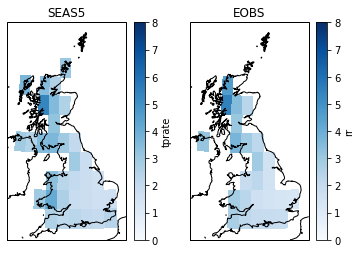

In [30]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.OSGB()})

SEAS5['tprate'].where(SEAS5_mask == 31).mean(
    dim=['time', 'leadtime', 'number']).plot(
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[0])

EOBS_upscaled['rr'].where(SEAS5_mask == 31).mean(dim='time').plot(
    transform=ccrs.PlateCarree(), 
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[1])

for ax in axs.flat:
    ax.coastlines(resolution='10m')

axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')

The additional mask of SEAS5 is where EOBS is not null:

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'SEAS5')

Text(0.5, 1.0, 'EOBS')

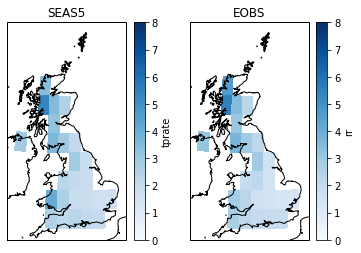

In [32]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.OSGB()})

(SEAS5['tprate']
 .where(SEAS5_mask == 31)
 .where(EOBS_upscaled['rr'].sel(time='1950').squeeze('time').notnull()) ## mask values that are nan in EOBS
 .mean(dim=['time', 'leadtime', 'number'])
 .plot(
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[0])
)

EOBS_upscaled['rr'].where(SEAS5_mask == 31).mean(dim='time').plot(
    transform=ccrs.PlateCarree(), 
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[1])

for ax in axs.flat:
    ax.coastlines(resolution='10m')

axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')

## And extract the spatial average

And now we can extract the UK averaged precipitation within SEAS5 by using the mask index of the UK: `where(SEAS5_mask == UK_index)`. 
So we need to find the index of one of the 241 abbreviations. In this case for the UK use 'GB'. Additionally, if you can't find a country, use `countries.regions` to get the full names of the countries.
 

In [13]:
countries.abbrevs.index('GB')

31

To select the UK average, we select SEAS5 precipitation (tprate), select the gridcells that are within the UK and take the area-weighted mean over those gridcells (more explanation in [1.4 Masking](1.4Mask.ipynb)). This results in a dataset of February precipitation for 35 years (1981-2016), with 5 leadtimes and 25 ensemble members.

In [14]:
Gridarea_SEAS5 = xr.open_dataset('../UK_example/Gridarea_SEAS5.nc')

In [38]:
SEAS5_UK_weighted = (SEAS5
                  .where(SEAS5_mask == 31)
                  .where(EOBS_upscaled['rr'].sel(time='1950').squeeze('time').notnull())
                  .weighted(Gridarea_SEAS5['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
SEAS5_UK_weighted

<xarray.Dataset>
Dimensions:   (leadtime: 5, number: 25, time: 35)
Coordinates:
  * time      (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * number    (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * leadtime  (leadtime) int64 2 3 4 5 6
Data variables:
    tprate    (leadtime, time, number) float64 1.62 1.803 3.715 ... 1.681 1.769

<xarray.Dataset>
Dimensions:  (time: 71)
Coordinates:
  * time     (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29
Data variables:
    rr       (time) float64 4.127 3.251 1.072 1.593 ... 2.774 1.498 1.782 4.92

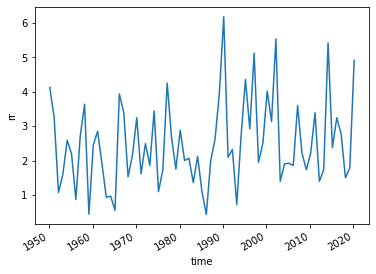

In [40]:
EOBS_UK_weighted = (EOBS_upscaled
                  .where(SEAS5_mask == 31) ## EOBS is now on the SEAS5 grid, so use the SEAS5 mask and gridcell area
                  .weighted(Gridarea_SEAS5['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
EOBS_UK_weighted
EOBS_UK_weighted['rr'].plot()

### Illustrate the SEAS5 and EOBS UK average

And the area-weighted average UK precipitation for SEAS5 and EOBS I plot here. For SEAS5 I plot the range, both min/max and the 2.5/97.5 % percentile of all ensemble members and leadtimes for each year.  

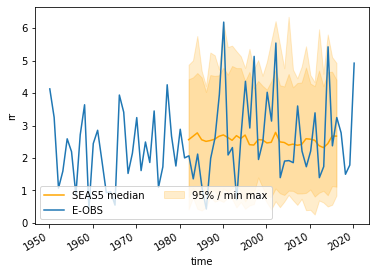

In [43]:
ax = plt.axes()

Quantiles = SEAS5_UK_weighted['tprate'].quantile([0,2.5/100, 0.5, 97.5/100,1], dim=['number','leadtime'])
ax.plot(Quantiles.time, Quantiles.sel(quantile=0.5), color='orange',label = 'SEAS5 median')
ax.fill_between(Quantiles.time.values, Quantiles.sel(quantile=0.025), Quantiles.sel(quantile=0.975), color='orange', alpha=0.2,label = '95% / min max')
ax.fill_between(Quantiles.time.values, Quantiles.sel(quantile=0), Quantiles.sel(quantile=1), color='orange', alpha=0.2)

EOBS_UK_weighted['rr'].plot(ax=ax,x='time',label = 'E-OBS')
plt.legend(loc = 'lower left', ncol=2 )#loc = (0.1, 0) upper left


### And save the UK weighted average datasets


In [26]:
xr.Dataset({"Precipitation": SEAS5_UK_weighted})#.to_dataframe().head()

<xarray.Dataset>
Dimensions:        (leadtime: 5, number: 25, time: 35)
Coordinates:
  * time           (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * number         (number) int32 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * leadtime       (leadtime) int64 2 3 4 5 6
Data variables:
    Precipitation  (leadtime, time, number) float64 1.62 1.803 ... 1.681 1.769

In [65]:
SEAS5_UK_weighted

SEAS5_UK_weighted_df.head()

SEAS5_UK_weighted_df.dtypes

<xarray.Dataset>
Dimensions:   (leadtime: 5, number: 25, time: 35)
Coordinates:
  * time      (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * number    (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * leadtime  (leadtime) int64 2 3 4 5 6
Data variables:
    tprate    (leadtime, time, number) float64 1.62 1.803 3.715 ... 1.681 1.769

tprate
leadtime number time                
2        0      1982-02-01  1.619839
                1983-02-01  2.929800
                1984-02-01  3.272816
                1985-02-01  2.000030
                1986-02-01  3.313016

tprate    float64
dtype: object

In [64]:
SEAS5_UK_weighted_df.index

MultiIndex([(2,  0, '1982-02-01'),
            (2,  0, '1983-02-01'),
            (2,  0, '1984-02-01'),
            (2,  0, '1985-02-01'),
            (2,  0, '1986-02-01'),
            (2,  0, '1987-02-01'),
            (2,  0, '1988-02-01'),
            (2,  0, '1989-02-01'),
            (2,  0, '1990-02-01'),
            (2,  0, '1991-02-01'),
            ...
            (6, 24, '2007-02-01'),
            (6, 24, '2008-02-01'),
            (6, 24, '2009-02-01'),
            (6, 24, '2010-02-01'),
            (6, 24, '2011-02-01'),
            (6, 24, '2012-02-01'),
            (6, 24, '2013-02-01'),
            (6, 24, '2014-02-01'),
            (6, 24, '2015-02-01'),
            (6, 24, '2016-02-01')],
           names=['leadtime', 'number', 'time'], length=4375)

In [45]:
SEAS5_UK_weighted.to_netcdf('Data/SEAS5_UK_weighted_masked.nc')
SEAS5_UK_weighted.to_dataframe().to_csv('Data/SEAS5_UK_weighted_masked.csv')
EOBS_UK_weighted.to_netcdf('Data/EOBS_UK_weighted_upscaled.nc') ## save as netcdf
EOBS_UK_weighted.to_dataframe().to_csv('Data/EOBS_UK_weighted_upscaled.csv') ## and save as csv. 

In [46]:
SEAS5_UK_weighted.close()
EOBS_UK_weighted.close()